In [21]:
# DATAJOINT
import datajoint as dj
dj.config.load('./utils/dj_mysql_conf.json')
c = dj.conn()

from schemata.cell import * 
import utils.NeuronTree as nt
import numpy as np
import pandas as pd

# PLOTTING
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the Persistence Diagram

In [8]:
key = dict(ds_id=2, c_num=25, reduction_id=0)
N = Neuron().get_tree(key)

In [29]:
#N.write_to_swc(path="./tmp/", file_name="L1_test_cell.swc")

In [14]:
# A selection of filter functions
def radial_distance(G, u, v):
    n = G.node[u]['pos']
    r = G.node[v]['pos']

    return np.sqrt(np.dot(n - r, n - r))

def height(G, u, v):
    n = G.node[u]['pos']
    r = G.node[v]['pos']
    return np.abs((n - r))[2]

import networkx as nx

def path_length(G, u, v):
    return nx.shortest_path_length(G, v, u, weight='path_length')

def branch_order(G, u, v):

    if u == v:
        bo = 0
    else:
        path = nx.shortest_path(G, v, u)
        bo = np.sum(np.array(list(nx.degree(G, path).values())) > 2)
    return bo

In [10]:
# The filter function so far takes a networkx graph and the respective node ids as input. 
# Maybe it makes mores sense to change it to a Morph object and the node ids
filter_function = radial_distance

df = N.get_mst().get_persistence(f=filter_function)

In [11]:
df

,birth,death,node_id,node_type
0,75.086391,42.834991,6214,2.0
1,89.492061,75.150699,2571,2.0
2,60.151446,25.131162,10444,2.0
3,67.477983,57.737283,5149,2.0
4,157.381166,146.697827,2089,2.0
5,153.325691,119.675867,1145,2.0
6,81.800787,69.402095,10867,2.0
7,116.211500,56.133865,13414,2.0
8,61.200668,65.332002,7286,2.0
9,219.333071,154.168450,4307,2.0


# Compute Morphometric Statistics

In [12]:
z = dict()

In [15]:
z['branch_points'] = N.get_branchpoints().size
extend = N.get_extend()

z['width'] = extend[0]
z['depth'] = extend[1]
z['height'] = extend[2]

tips = N.get_tips()

z['tips'] = tips.size

z['stems'] = len(N.edges(1))

z['total_length'] = np.sum(list(nx.get_edge_attributes(N.get_graph(), 'path_length').values()))
# get all radii
radii = nx.get_node_attributes(N.get_graph(), 'radius')
# delete the soma
radii.pop(N.get_root())
z['avg_thickness'] = np.mean(list(radii.values()))
z['max_thickness'] = np.max(list(radii.values()))

z['total_surface'] = np.sum(list(N.get_surface().values()))
z['total_volume'] = np.sum(list(N.get_volume().values()))

z['max_path_dist_to_soma'] = np.max(N.get_distance_dist()[1])
z['max_branch_order'] = np.max(list(N.get_branch_order().values()))

path_angles = []
for p1 in N.get_path_angles().items():
    if p1[1].values():
        path_angles += list(list(p1[1].values())[0].values())

z['max_path_angle'] = np.percentile(path_angles,99.5)
z['min_path_angle'] = np.min(path_angles)
z['median_path_angle'] = np.median(path_angles)

R = N.get_mst()
segment_length = R.get_segment_length()
terminal_segment_pl = [item[1] for item in segment_length.items() if item[0][1] in tips]
intermediate_segment_pl = [item[1] for item in segment_length.items() if item[0][1] not in tips]

z['max_segment_path_length'] = np.max(list(segment_length.values()))
z['median_intermediate_segment_pl'] = np.median([0] + intermediate_segment_pl)
z['median_terminal_segment_pl'] = np.median(terminal_segment_pl)

tortuosity = [e[2]['path_length'] / e[2]['euclidean_dist'] for e in R.edges(data=True)]

z['max_tortuosity'] = np.log(np.percentile(tortuosity,99.5))
z['min_tortuosity'] = np.log(np.min(tortuosity))
z['median_tortuosity'] = np.log(np.median(tortuosity))

branch_angles = R.get_branch_angles()
z['max_branch_angle'] = np.max(branch_angles)
z['min_branch_angle'] = np.min(branch_angles)
z['mean_branch_angle'] = np.mean(branch_angles)

# get maximal degree within data
z['max_degree'] = np.max([item[1] for item in R.get_graph().out_degree().items() if item[0] != R.get_root()])

# get tree asymmetry
weights, psad = R.get_psad()
if np.sum(list(weights.values())) != 0:
    z['tree_asymmetry'] = np.sum([weights[k]*psad[k] for k in psad.keys()])/np.sum(list(weights.values()))
else:
    z['tree_asymmetry'] = 0

In [16]:
z

{'avg_thickness': 0.14393072521321548,
 'branch_points': 107,
 'depth': 86.65244811540327,
 'height': 128.29000000000002,
 'max_branch_angle': 178.18986330176983,
 'max_branch_order': 22,
 'max_degree': 3,
 'max_path_angle': 121.69340798976552,
 'max_path_dist_to_soma': 798.161003480817,
 'max_segment_path_length': 307.737173828897,
 'max_thickness': 7.47866586639495,
 'max_tortuosity': 1.8811878989560245,
 'mean_branch_angle': 74.57860493429285,
 'median_intermediate_segment_pl': 25.107882833940906,
 'median_path_angle': 10.151116766905487,
 'median_terminal_segment_pl': 64.9686058371587,
 'median_tortuosity': 0.2801999698731242,
 'min_branch_angle': 7.867697418883542,
 'min_path_angle': 0.0,
 'min_tortuosity': 0.00130087508079766,
 'stems': 5,
 'tips': 112,
 'total_length': 13251.659086698703,
 'total_surface': 12384.993191495898,
 'total_volume': 4515.048054157633,
 'tree_asymmetry': 0.7392180795087548,
 'width': 514.24}

# Compute Density Maps

In [18]:
dist = 1 # in microns

# get the resampled point could along each neurite at distance 1 micron. pc is an array of 3D coordinates for each resampled node
pc = nt.NeuronTree.resample_nodes(N.get_graph(), dist) 

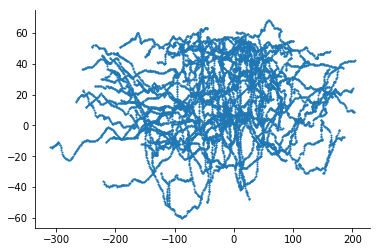

In [24]:
plt.scatter(pc[:,0], pc[:,2], s=1)
sns.despine()